In [67]:
from keras.preprocessing import image
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import numpy as np

## Load training, validation, and test datasets

In [68]:
#initialize image data generator
datagen = image.ImageDataGenerator()

In [140]:
# load training dataset as generator
train_it = datagen.flow_from_directory('balanced/train/', class_mode='categorical', batch_size=64,target_size=(224, 224))

Found 3299 images belonging to 3 classes.


In [141]:
train_it.class_indices

{'BACTERIA': 0, 'NORMAL': 1, 'VIRUS': 2}

In [70]:
# load validation dataset as generator
val_it = datagen.flow_from_directory('balanced/val/', class_mode='categorical', batch_size=64, target_size=(224, 224))

Found 483 images belonging to 3 classes.


In [71]:
# load testing dataset as generator
test_it = datagen.flow_from_directory('balanced/test/', class_mode='categorical', batch_size=64, target_size=(224, 224))

Found 448 images belonging to 3 classes.


## Define input layer shape

In [72]:
image_input = Input(shape=(224, 224, 3))

## Define global epochs

In [73]:
custom_epochs = 5

## Basiced on transferlearning result from classification of normal and pneumonia, VGG16 and VGG19 have the best accuracy so we are going to implement VGG16 and VGG19, To see if we can classify normal, vrius and bacteria pneumonia

## Transfer learning using VGG16

In [74]:
from keras.applications.vgg16 import VGG16

In [75]:
model = VGG16()

In [76]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [77]:
model = VGG16(input_tensor=image_input, include_top=True)

In [78]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Replace the output layer with my custom output layer

In [79]:
last_layer = model.get_layer('fc2').output

In [80]:
out = Dense(3, activation='softmax', name='output')(last_layer)

In [81]:
custom_vgg16_3c = Model(image_input, out)

In [82]:
custom_vgg16_3c.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Freeze all layers but the last

In [83]:
for layer in custom_vgg16_3c.layers[:-1]:
    layer.trainable = False

In [84]:
custom_vgg16_3c.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [85]:
custom_vgg16_3c.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy', Precision(), Recall()]
)

### Create model checkpoint

In [86]:
checkpoint = ModelCheckpoint('custom_vgg16_3c_best_weights.h5', verbose=1, save_best_only=True)

### Train the model

In [87]:
h = custom_vgg16_3c.fit_generator(
    train_it, 
    steps_per_epoch=16, 
    validation_data=val_it, 
    validation_steps=8,
    callbacks=[checkpoint],
    epochs=custom_epochs
)

Epoch 1/5
16/16 [==============================] - 412s 26s/step - loss: 1.6675 - accuracy: 0.5085 - precision_3: 0.5201 - recall_3: 0.4945 - val_loss: 0.7028 - val_accuracy: 0.4451 - val_precision_3: 0.4440 - val_recall_3: 0.4431

Epoch 00001: val_loss improved from inf to 0.70278, saving model to custom_vgg16_3c_best_weights.h5
Epoch 2/5
16/16 [==============================] - 386s 24s/step - loss: 0.9673 - accuracy: 0.6377 - precision_3: 0.6466 - recall_3: 0.6201 - val_loss: 0.8201 - val_accuracy: 0.7619 - val_precision_3: 0.7724 - val_recall_3: 0.7308

Epoch 00002: val_loss did not improve from 0.70278
Epoch 3/5
16/16 [==============================] - 381s 24s/step - loss: 0.8858 - accuracy: 0.6660 - precision_3: 0.6805 - recall_3: 0.6553 - val_loss: 0.5372 - val_accuracy: 0.7723 - val_precision_3: 0.7974 - val_recall_3: 0.7578

Epoch 00003: val_loss improved from 0.70278 to 0.53723, saving model to custom_vgg16_3c_best_weights.h5
Epoch 4/5
16/16 [==============================] 

### Plot metrics

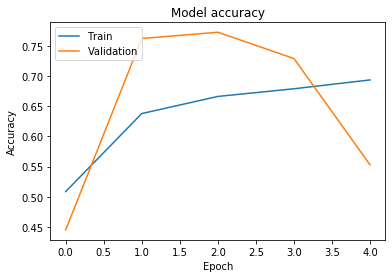

In [88]:
# Plot training & validation accuracy values
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

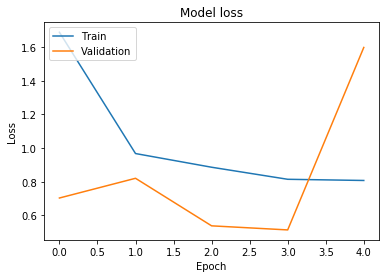

In [91]:
# Plot training & validation loss values
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

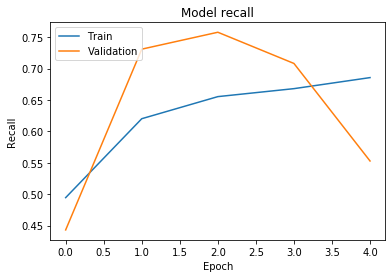

In [93]:
# Plot training & validation recall values
plt.plot(h.history['recall_3'])
plt.plot(h.history['val_recall_3'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

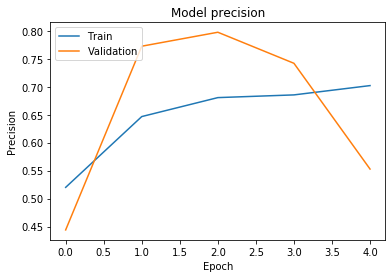

In [94]:
# Plot training & validation precision values
plt.plot(h.history['precision_3'])
plt.plot(h.history['val_precision_3'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Evaluate the model against the test dataset

In [95]:
# evaluate model
# load the best weights 
custom_vgg16_3c.load_weights('custom_vgg16_3c_best_weights.h5')
metrics_result = custom_vgg16_3c.evaluate_generator(test_it, steps=24)

### Evaluation results

In [96]:
print(f'{custom_vgg16_3c.metrics_names[0]}: {metrics_result[0]}' )
print(f'{custom_vgg16_3c.metrics_names[1]}: {"{:.2%}".format(metrics_result[1])}' )
print(f'{custom_vgg16_3c.metrics_names[2]}: {"{:.2%}".format(metrics_result[2])}' )
print(f'{custom_vgg16_3c.metrics_names[3]}: {"{:.2%}".format(metrics_result[3])}' )

loss: 0.9411787986755371
accuracy: 62.24%
precision_3: 62.62%
recall_3: 60.74%


## Transfer learning using VGG19

In [97]:
from keras.applications.vgg19 import VGG19

In [98]:
model = VGG19(input_tensor=image_input, include_top=True)

### Replace ouput layer with my custom output layer

In [99]:
last_layer = model.get_layer('fc2').output

In [100]:
out = Dense(3, activation='softmax', name='output')(last_layer)

In [101]:
custom_vgg19_3c = Model(image_input, out)

In [102]:
custom_vgg19_3c.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Freeze all layers but the last

In [103]:
for layer in custom_vgg19_3c.layers[:-1]:
    layer.trainable = False

In [104]:
custom_vgg19_3c.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [105]:
custom_vgg19_3c.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy', Precision(), Recall()]
)

### Create model checkpoint

In [106]:
checkpoint = ModelCheckpoint('custom_vgg19_3c_best_weights.h5', verbose=1, save_best_only=True)

### Train the model

In [107]:
h = custom_vgg19_3c.fit_generator(
    train_it, 
    steps_per_epoch=16, 
    validation_data=val_it, 
    validation_steps=8,
    callbacks=[checkpoint],
    epochs=custom_epochs
)

Epoch 1/5
16/16 [==============================] - 536s 33s/step - loss: 1.6222 - accuracy: 0.5498 - precision_4: 0.5615 - recall_4: 0.5352 - val_loss: 1.1883 - val_accuracy: 0.5694 - val_precision_4: 0.5754 - val_recall_4: 0.5611

Epoch 00001: val_loss improved from inf to 1.18830, saving model to custom_vgg19_3c_best_weights.h5
Epoch 2/5
16/16 [==============================] - 580s 36s/step - loss: 0.8528 - accuracy: 0.6562 - precision_4: 0.6670 - recall_4: 0.6357 - val_loss: 1.5135 - val_accuracy: 0.6190 - val_precision_4: 0.6234 - val_recall_4: 0.6170

Epoch 00002: val_loss did not improve from 1.18830
Epoch 3/5
16/16 [==============================] - 520s 32s/step - loss: 0.9520 - accuracy: 0.6442 - precision_4: 0.6485 - recall_4: 0.6322 - val_loss: 0.8776 - val_accuracy: 0.6128 - val_precision_4: 0.6164 - val_recall_4: 0.6087

Epoch 00003: val_loss improved from 1.18830 to 0.87755, saving model to custom_vgg19_3c_best_weights.h5
Epoch 4/5
16/16 [==============================] 

### Plot metrics

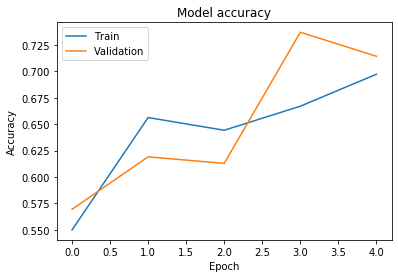

In [108]:
# Plot training & validation accuracy values
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

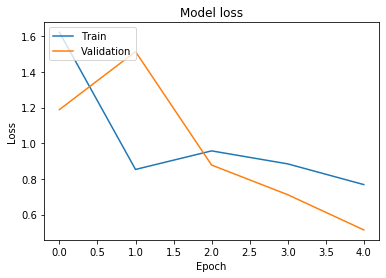

In [109]:
# Plot training & validation loss values
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

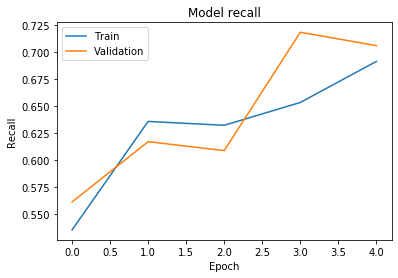

In [112]:
# Plot training & validation recall values
plt.plot(h.history['recall_4'])
plt.plot(h.history['val_recall_4'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

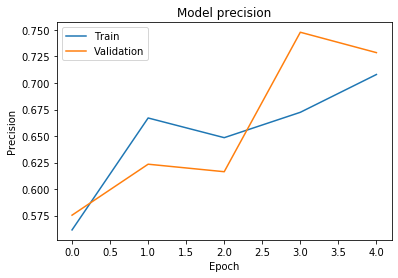

In [113]:
# Plot training & validation precision values
plt.plot(h.history['precision_4'])
plt.plot(h.history['val_precision_4'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Evaluate the model against the test dataset

In [114]:
# evaluate model
# load the best weights 
custom_vgg19_3c.load_weights('custom_vgg19_3c_best_weights.h5')
metrics_result = custom_vgg19_3c.evaluate_generator(test_it, steps=24)

### Evaluation results

In [116]:
print(f'{custom_vgg19_3c.metrics_names[0]}: {metrics_result[0]}' )
print(f'{custom_vgg19_3c.metrics_names[1]}: {"{:.2%}".format(metrics_result[1])}' )
print(f'{custom_vgg19_3c.metrics_names[2]}: {"{:.2%}".format(metrics_result[2])}' )
print(f'{custom_vgg19_3c.metrics_names[3]}: {"{:.2%}".format(metrics_result[3])}' )

loss: 1.7556359767913818
accuracy: 61.59%
precision_4: 62.24%
recall_4: 60.74%


## VGG16 and VGG19 perform about the same

In [137]:
#create a make prediction function
custom_vgg16_3c.load_weights('custom_vgg16_3c_best_weights.h5')
def make_prediction(image_path):
    try:
        categories = ['Bacteria Pneumonia', 'Normal', 'Vrius Pneumonia']
        img = image.load_img(image_path, target_size=(224, 224))
        img_tensor = image.img_to_array(img)
        img_tensor = np.expand_dims(img_tensor, axis=0)
        pred = custom_vgg16_3c.predict(img_tensor)
        print(pred)
        print('********Diagnostic Result***********')
        print('>>>> ',categories[np.argmax(pred[0])], "{:.2%}".format(pred[0][np.argmax(pred[0])]))
        print('*************************************')
        img_tensor/=255
        plt.imshow(img_tensor[0])
    except:
        print('Invalid image file!')
        return

[[3.917393e-02 7.810378e-05 9.607480e-01]]
********Diagnostic Result***********
>>>>  Vrius Pneumonia 96.07%
*************************************


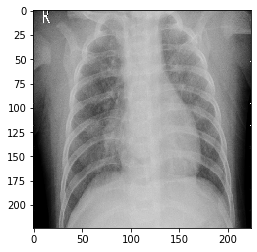

In [144]:
make_prediction('balanced/test/VIRUS/person1618_virus_2805.jpeg')

[[0.6903534  0.00106219 0.3085844 ]]
********Diagnostic Result***********
>>>>  Bacteria Pneumonia 69.04%
*************************************


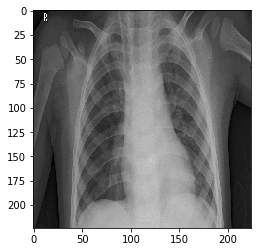

In [145]:
make_prediction('balanced/test/BACTERIA/person153_bacteria_725.jpeg')

[[0.29828522 0.42058495 0.2811298 ]]
********Diagnostic Result***********
>>>>  Normal 42.06%
*************************************


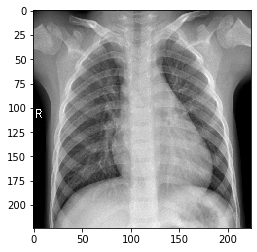

In [139]:
make_prediction('balanced/test/NORMAL/NORMAL2-IM-0353-0001.jpeg')